<h1 align="center">Progress Report 2015-06-26</h1>

# Goal

# Done
* Strong-scaling experiments in USP cloud
* First map stage analysis (detailed below)
* Japanese classes
  * Grammar test
  * Kanji test
  * Learned how to wear Yukata
* Small surgery

Predict the total map duration based on the map task durations, amount of workers and input data size.

# Strong-Scaling Experiment

Find below some information about the experiment whose logs are analysed in this work.

In [1]:
# Notebook configuration and modules import

import glob

# Show graph in this notebook instead of opening a window
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from sparklogstats import LogParser

In [3]:
apps, worker_amounts = parse_strong_scaling()

In [4]:
file_size = 48542876756
block_size = 128 * 1024 * 1024
n_blocks = int(file_size/block_size + 0.5)
n_tasks = set([len(app.stages[0].tasks) for app in apps])
assert len(n_tasks) == 1  # All executions have the same number of tasks
n_tasks = n_tasks.pop()
assert n_blocks == n_tasks  # 1 task per block

info = '* Input size: {:.1f} GB\n'.format(file_size/1024**3)
info += '* Input blocks (128 MB each) == map tasks: {:d}\n'.format(n_blocks)
info += '* Worker amounts: {}\n'.format(', '.join((str(w) for w in worker_amounts)))
info += '* Executions: {:d} (30 for each worker amount, 1 outlier removed)\n'.format(len(apps))
info += '* Total map tasks: {:d} x {:d} = {:d}'.format(len(apps), n_tasks, len(apps) * n_tasks)
Markdown(info)

* Input size: 45.2 GB
* Input blocks (128 MB each) == map tasks: 362
* Worker amounts: 4, 8, 16, 32, 64
* Executions: 149 (30 for each worker amount, 1 outlier removed)
* Total map tasks: 149 x 362 = 53938

## Map stage durations
The figure below shows the map durations from all the executions. The line that connects their means will be used in other figures to compare with the model results.

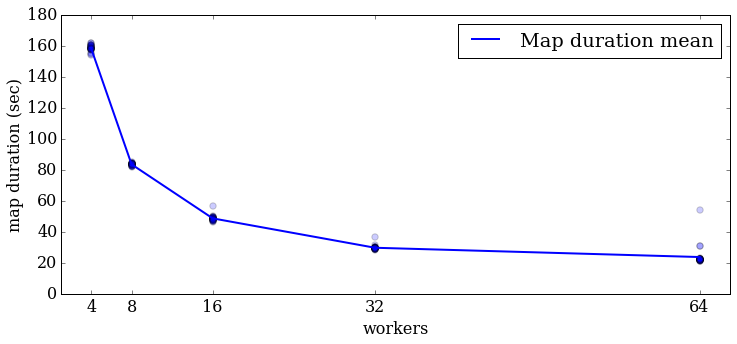

All map stage durations and their means per worker amount.

In [5]:
plt.subplots(figsize=(12,5))

# Scatter plot with all map durations
map_time_workers, map_durations = [], []
for app in apps:
    map_durations.append(app.stages[0].tasks_duration()/1000)
    map_time_workers.append(app.workers)
plt.scatter(map_time_workers, map_durations, alpha=0.2, s=40)
plt.xticks(worker_amounts)
plt.xlabel('workers')
plt.ylabel('map duration (sec)')

# Line with the mean map duration for each worker amount
map_means = []
for workers in worker_amounts:
    _apps = (a for a in apps if a.workers == workers)
    _ys = [app.stages[0].tasks_duration()/1000 for app in _apps]
    map_means.append(np.mean(_ys))
plt.plot(worker_amounts, map_means, label='Map duration mean')
plt.legend()
plt.show()
Markdown('All map stage durations and their means per worker amount.')

# Mean model

The model uses the task time durations to predict the whole map durations. In this first approach, we first calculate the mean duration of all tasks (~54k tasks). Then, we multiply it by the number of tasks each worker will execute.

The tasks are distributed evenly across all the nodes and, if some worker executes more tasks than other, we consider the highest amount of tasks. In this experiment, each worker has 2 threads. The total map duration is calculate by the function below.

In [6]:
# total time = (highest) number of tasks per worker x task time mean
def mean_model(workers, tasks, mean):
    threads = 2 * workers
    return np.ceil(tasks/threads) * mean

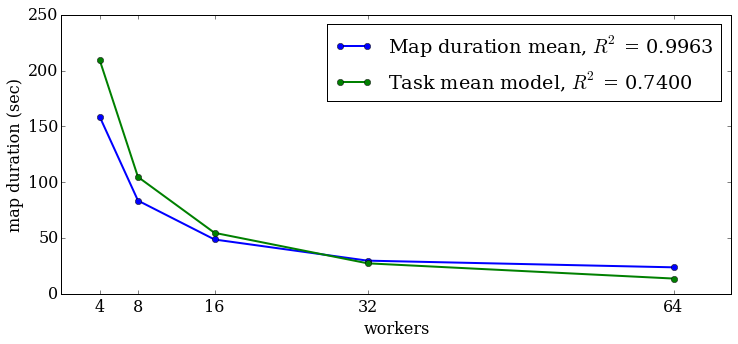

Comparison between the average of map durations and the model based on the mean of all tasks.

In [7]:
plt.subplots(figsize=(12,5))

# r-squared calculation
y_mean = np.mean(map_durations)
sst = sum(((y - y_mean)**2 for y in map_durations))
def calc_r2(model):
    sse = 0
    for x, y in zip(map_time_workers, map_durations):
        y_ = model(x)
        sse += (y - y_)**2
    return (sst - sse)/sst

# The same mean line as previous figure, but with its r-squared value
def get_mean(x): return map_means[worker_amounts.index(x)]
r2 = calc_r2(get_mean)
map_label = 'Map duration mean, ' + r'$R^{2}$' + ' = {:.4f}'.format(r2)
plt.plot(worker_amounts, map_means, '-o', label=map_label)

# Using the mean model
task_durations = [t.duration for a in apps for t in a.stages[0].tasks]
mean = np.mean(task_durations) / 1000
def model(x): return mean_model(x, n_tasks, mean)
mean_model_ys = [model(x) for x in worker_amounts]
r2 = calc_r2(model)
mean_model_label = 'Task mean model, ' + r'$R^{2}$' + ' = {:.4f}'.format(r2)
plt.plot(worker_amounts, mean_model_ys, '-o', label=mean_model_label)

plt.xlabel('workers')
plt.ylabel('map duration (sec)')
plt.xticks(worker_amounts)
plt.legend()
plt.show()

Markdown('Comparison between the average of map durations and the model based on the mean of all tasks.')

As we can notice, the prediction error is bigger as the amount of worker goes below 16 or beyond 32.

# Task duration distribution
To improve the model, we should understand the distribution of the map stage tasks.

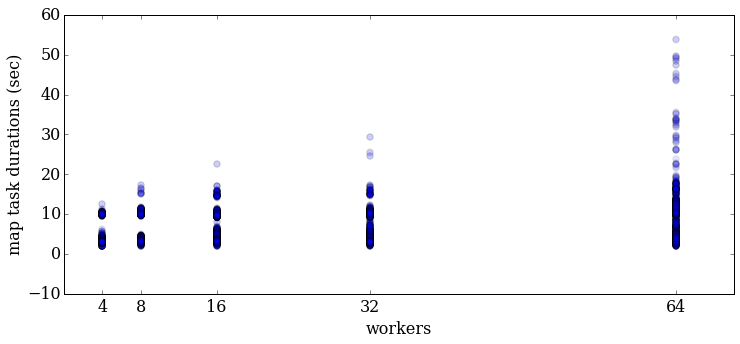

Duration of all tasks from all executions grouped by worker amount.

In [8]:
# Map task durations
plt.subplots(figsize=(12,5))

for app in apps:
    _ys = [t.duration/1000 for t in app.stages[0].tasks]
    _xs = [app.workers] * len(_ys)
    plt.scatter(_xs, _ys, alpha=0.1, s=40)

plt.xticks(worker_amounts)
plt.xlabel('workers')
plt.ylabel('map task durations (sec)')
plt.show()

Markdown('Duration of all tasks from all executions grouped by worker amount.')

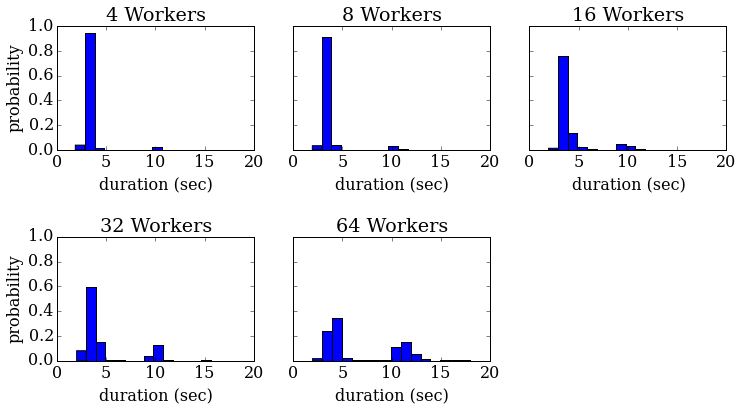

Histograms of task durations.

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(12,6), sharey=True)
axs[-1, -1].axis('off')
fig.subplots_adjust(hspace=0.7)

for n, workers in enumerate(worker_amounts):
    ax = axs[int(n/3)][n%3]
    _apps = (a for a in apps if a.workers == workers)
    durations = np.array([t.duration/1000 for a in _apps for t in a.stages[0].tasks])
    bins = max(durations) - min(durations) + 1
    ax.hist(durations, bins, normed=True)
    ax.set_xlabel('duration (sec)')
    ax.set_xlim(0, 20)
    ax.set_ylim(0, 1)
    ax.set_title('{:d} Workers'.format(workers))
    if n == 0 or n == 3:
        ax.set_ylabel('probability')
    #if workers == 64:
    #    ax.set_yticks(np.arange(0, 0.41, 0.1))
plt.show()

Markdown('Histograms of task durations.')

In the histograms above, a second curve around 10 seconds becomes more evident as the number of workers increases. In the next section, we investigate the longer tasks

## Longer tasks

We now analyse only the tasks that take longer than 8 seconds to finish.

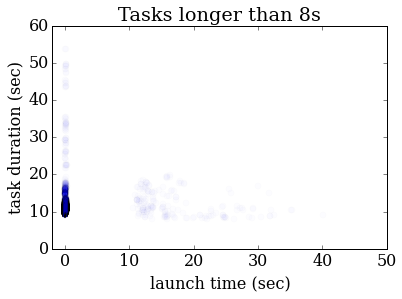

Longer tasks and their launch time since the first map task start.

In [10]:
for app in apps:
    map_tasks = [t for t in app.stages[0].tasks if t.duration >= 8000]
    _ys = [task.duration/1000 for task in map_tasks]
    _xs = np.array([task.start for task in map_tasks])
    _xs = (_xs - min(_xs))/1000
    plt.scatter(_xs, _ys, alpha=0.01, s=40)
plt.xlim(xmin=-2)
plt.ylabel('task duration (sec)')
plt.xlabel('launch time (sec)')
plt.title('Tasks longer than 8s')
plt.show()

Markdown('Longer tasks and their launch time since the first map task start.')

The figure above reveals that the longer tasks are highly concentrated in the very beginning of the map phase.
The cumulative distribution function below can give us more information.

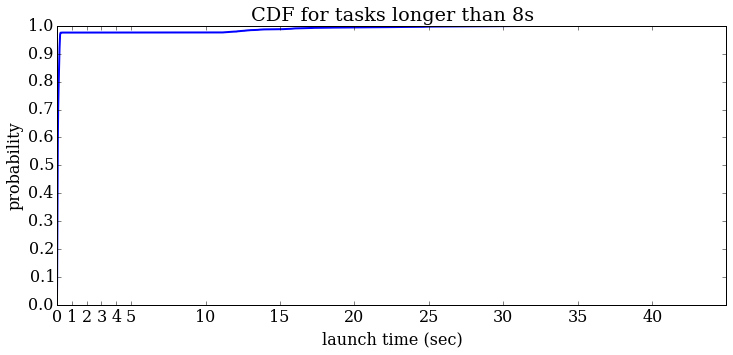

Cumulative distribution function of the tasks longer than 8 seconds.

In [11]:
plt.subplots(figsize=(12,5))

starts = []
for app in apps:
    _starts = np.array([t.start for t in app.stages[0].tasks if t.duration >= 8000])
    starts.extend((_starts - min(_starts))/1000)
starts.sort()    

_xs = [starts[0]]
_ys = [1]
for start in starts[1:]:
    if start == _xs[-1]:
        _ys[-1] += 1
    else:
        _xs.append(start)
        _ys.append(1)

_ys = np.array(_ys)
_ys = _ys/_ys.sum()

plt.plot(_xs, _ys.cumsum(), linewidth=2)
plt.title('CDF for tasks longer than 8s')
plt.xlabel('launch time (sec)')
plt.ylabel('probability')
plt.xticks(list(range(0,6)) + list(range(10, 45, 5)))
plt.yticks(np.linspace(0, 1, 11))
plt.ylim(ymax=1)
plt.show()

Markdown('Cumulative distribution function of the tasks longer than 8 seconds.')

We can notice in the CDF that more than 95% of the slowest tasks start up to 1 second after the first map.

In [12]:
# Fastest task duration, in seconds
min((t.duration for app in apps for t in app.stages[0].tasks))/1000

1.878

As the fastest task has more than one second (as calculated above), we conclude that the vast majority of the longer tasks are the first ones to be scheduled. With that in mind, we propose another model discussed below.

# Two-mean model

Based on the distribution of the task durations, we evaluate a model with based on two means: one for the first tasks to be executed in each thread and another for all the other tasks. The total map duration time includes the higher mean value to process the first tasks in parallel. More time is added using the remaining tasks and the lower mean as in the previous model.

In [13]:
def two_mean_model(workers, tasks, high_mean, low_mean):
    """asdasd
      workers: amount of workers
        tasks: number of tasks
    high_mean: mean duration of the first tasks
     low_mean: mean duration of the remaining tasks
    """
    total_time = high_mean  # all the workers process their first task
    threads = 2 * workers
    total_time += mean_model(workers, tasks - threads, low_mean)
    return total_time

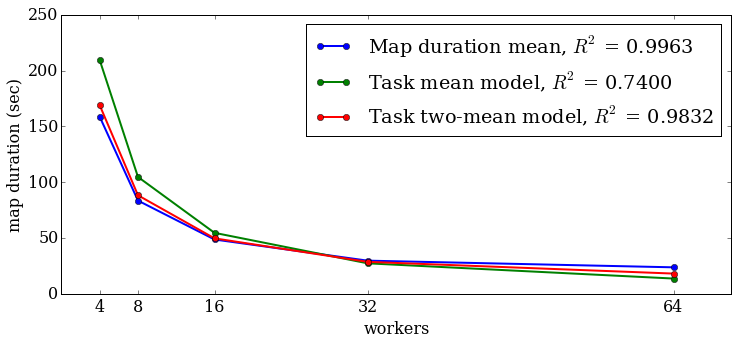

In [14]:
plt.subplots(figsize=(12,5))

def get_two_mean_durations(apps):
    slow_tasks, fast_tasks = [], []
    for a in apps:
        threads = 2*a.workers
        slow_tasks.extend([t.duration for t in a.stages[0].tasks[:threads]])
        fast_tasks.extend([t.duration for t in a.stages[0].tasks[threads:]])
    low = np.mean(fast_tasks) / 1000
    high = np.mean(slow_tasks) / 1000
    
    def model(x):
        return two_mean_model(x, n_tasks, high, low)
    
    ys = [model(x) for x in worker_amounts]
    r2 = calc_r2(model)
    
    return ys, r2

plt.plot(worker_amounts, map_means, '-o', label=map_label)
plt.plot(worker_amounts, mean_model_ys, '-o', label=mean_model_label)

# Two-mean model
two_mean_model_ys, r2 = get_two_mean_durations(apps)
two_mean_model_label = 'Task two-mean model, ' + r'$R^{2}$' + ' = {:.4f}'.format(r2)
plt.plot(worker_amounts, two_mean_model_ys, '-o', label=two_mean_model_label)

plt.xlabel('workers')
plt.ylabel('map duration (sec)')
plt.xticks(worker_amounts)
plt.legend()
plt.show()

The two-mean model is much closer to the map duration mean than the previous model. With this better model, we use an execution with less resources to predict the strong-scaling experiment.

# Profiling phase

In the previous sections, we used the task durations from the strong-scaling experiment. However, in real life, we want to use as few resources (and money) as possible to predict the application scalability. In this section, we  use *only one worker and only one gigabyte of input data*.

* Input size: 1 GB
* Input blocks (128 MB each) == map tasks: 8
* Worker amounts: 1
* Executions: 30
* Total map tasks: 8 x 30 = 240

In [15]:
apps_weak1, _ = parse_weak_scaling(workers=1)

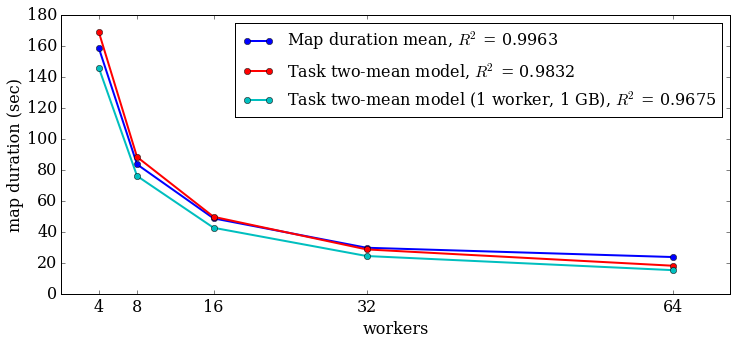

Two-mean model with reduced resource execution.

In [16]:
plt.subplots(figsize=(12,5))

plt.plot(worker_amounts, map_means, 'b-o', label=map_label)
plt.plot(worker_amounts, two_mean_model_ys, 'r-o', label=two_mean_model_label)

ys, r2 = get_two_mean_durations(apps_weak1)
label = 'Task two-mean model (1 worker, 1 GB), ' + r'$R^{2}$' + ' = {:.4f}'.format(r2)
plt.plot(worker_amounts, ys, 'c-o', label=label)

plt.xlabel('workers')
plt.ylabel('map duration (sec)')
plt.xticks(worker_amounts)
plt.legend(fontsize=16)
plt.show()

Markdown('Two-mean model with reduced resource execution.')

# Conclusion

By running the application with 45 times less data in only one VM, it was possible to predict the map stage time within a satisfactory accuracy for the entire input data and several worker amounts.

# Next Steps
* Reduce stage prediction (a quick look revealed the same pattern)
* Other stages
* Total application time modeling